# Exercises for Introduction to Quantum Computing

Name: Pugazharasu Anancia Devaneyan (s6puanan) <br />
Matriculation number: 3300280

In [15]:
import numpy as np
import qiskit as qi
from qiskit import IBMQ, Aer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, transpile, execute
import cmath
import math
from qiskit.visualization import plot_histogram

## 1. Quantum Fourier Transform (continued)

For a state,
$$| \psi (x=1) \rangle = \frac{1}{\sqrt{8}}\sum^{7}_{k=0} e^{2\pi i \frac{k}{8}}| k \rangle$$
applying the inverse qFT, 
$$qFT^{\dagger} = \frac{1}{\sqrt{8}}\sum^{7}_{j=0} e^{-2\pi i \frac{kj}{8}}| j \rangle$$
gives us,
$$qFT^{\dagger} | \psi (x=1) \rangle = \frac{1}{8}\sum^{7}_{j=0} \sum^{7}_{k=0} e^{-2\pi i \frac{kj}{8}}e^{2\pi i \frac{k}{8}}| j \rangle$$
$$qFT^{\dagger} | \psi (x=1) \rangle = \frac{1}{8}\sum^{7}_{j=0} \sum^{7}_{k=0} e^{2\pi i \frac{k(1-j)}{8}}| j \rangle$$
$$qFT^{\dagger} | \psi (x=1) \rangle = \frac{1}{8}\left( | 000 \rangle + | 001 \rangle  +  \right)$$

For a state,
$$| \psi (x=\frac{1}{2}) \rangle = \frac{1}{\sqrt{8}}\sum^{7}_{k=0} e^{2\pi i \frac{k}{16}}| k \rangle$$
applying the inverse qFT gives us,
$$qFT^{\dagger}| \psi (x=\frac{1}{2}) \rangle = \frac{1}{8}\sum^{7}_{j=0} \sum^{7}_{k=0} e^{-2\pi i \frac{kj}{8}}e^{2\pi i \frac{k}{16}}| j \rangle$$
We can compute the probability of measuring 0 after measurement by computing ${|\langle 000|qFT^{\dagger}| \psi (x=\frac{1}{2}) \rangle|}^{2}$,
$$|\langle 000|qFT^{\dagger}| \psi (x=\frac{1}{2}) \rangle|^{2} = |\frac{1}{8}\sum^{7}_{k=0} e^{\pi i \frac{k}{8}}|^{2}$$
Evaluating the sum, we get,
$$|\langle 000|qFT^{\dagger}| \psi (x=\frac{1}{2}) \rangle|^{2} = 0.41$$

In [21]:
sum = 0
for prod in range(8):
    sum += cmath.exp(1j*(prod*math.pi/8))
display(sum)
sum = (np.abs(sum)**2)/64
display(sum)

(1.0000000000000007+5.027339492125848j)

0.4105334745170029

In [26]:
sum = 0
for prod in range(8):
    sum += cmath.exp(-1j*(prod*math.pi/8))
display(sum)
sum = (np.abs(sum)**2)/64
display(sum)

(1.0000000000000007-5.027339492125848j)

0.4105334745170029

Now, to compute the probability of measuring 0 or 1, we simply need to compute
$$|\langle 001|qFT^{\dagger}| \psi (x=\frac{1}{2}) \rangle|^{2} = |\frac{1}{8}\sum^{7}_{k=0} e^{-\pi i \frac{k}{8}}|^{2}$$
and add it to the previous result. Computing the sum,
$$|\langle 001|qFT^{\dagger}| \psi (x=\frac{1}{2}) \rangle|^{2} = 0.41$$
Thus, the pobability of observing 0 or 1 = 0.82

We shall now evaluate the using Qiskit. We begin by intialising the state,

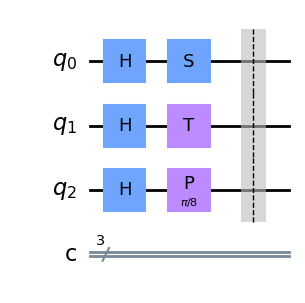

In [9]:
inv_qFT = QuantumCircuit(3,3)
inv_qFT.h(0)
inv_qFT.h(1)
inv_qFT.h(2)
inv_qFT.s(0)
inv_qFT.t(1)
inv_qFT.p(np.pi/8,2)
inv_qFT.barrier()
inv_qFT.draw('mpl')

Now we implement the $qFT^{\dagger}$

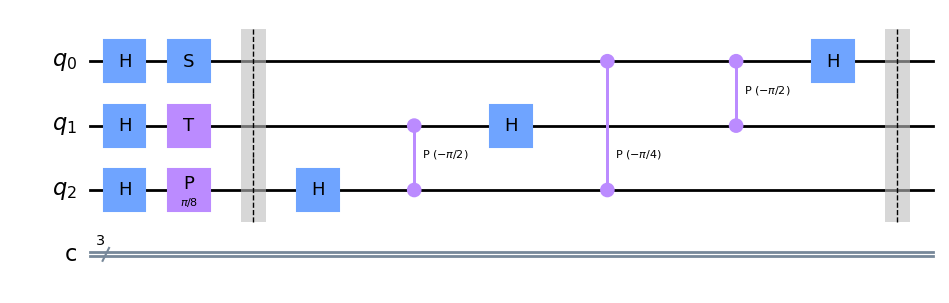

In [10]:
inv_qFT.h(2)
inv_qFT.cp(-np.pi/2, 2, 1)
inv_qFT.h(1)
inv_qFT.cp(-np.pi/4, 2, 0)
inv_qFT.cp(-np.pi/2, 1, 0)
inv_qFT.h(0)
inv_qFT.barrier()

inv_qFT.draw('mpl')

In [5]:
def swap_registers(circuit, n):
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit

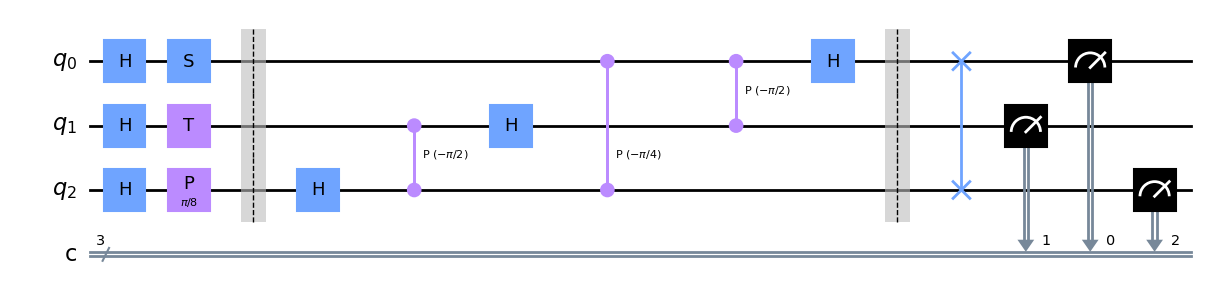

In [11]:
inv_qFT = swap_registers(inv_qFT,3)
inv_qFT.measure([0,1,2],[0,1,2]) 
inv_qFT.draw('mpl')

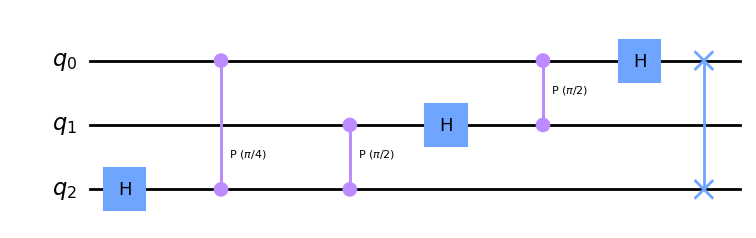

In [23]:
def swap_registers(circuit, n):
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit

def qft(circuit, n):
    """QFT on the first n qubits in circuit"""
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

# Let's see how it looks:
qc = QuantumCircuit(3)
qft(qc,3)
qc.draw('mpl')

In [12]:
simulator = Aer.get_backend('qasm_simulator')
result = execute(inv_qFT,backend=simulator, shots = 10000).result()
results = result.get_counts()
display(results)

{'100': 4060,
 '000': 4194,
 '010': 1389,
 '011': 54,
 '101': 50,
 '111': 5,
 '001': 248}

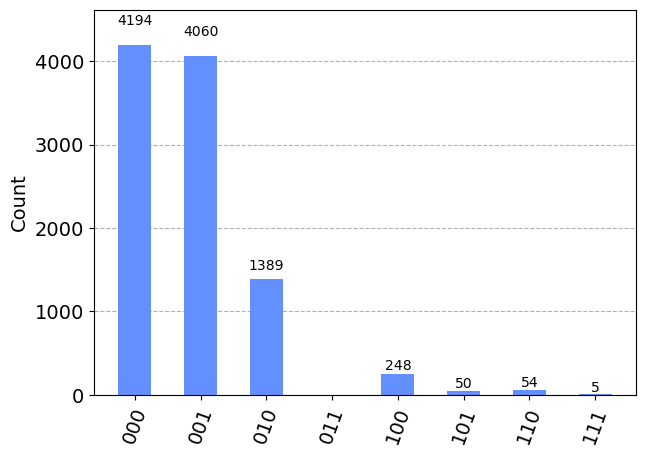

In [13]:
NQ_odering = {}
for q0 in range(2):
    for q1 in range(2):
        for q2 in range(2):
            myin = str(q2)+ str(q1) + str(q0)
            myout = str(q0) + str(q1) + str(q2)
            age = results.get(myin)
            if age:
                NQ_odering[myout] = results[myin]
            else:
                results[myin] = 0
                NQ_odering[myout] = results[myin]
plot_histogram(NQ_odering)